<a href="https://colab.research.google.com/github/sagarkhule/fraud_detection/blob/main/Fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. Import**

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import average_precision_score
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance, to_graphviz

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [11]:
df = pd.read_csv('/Fraud (1).csv')
df = df.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig', \
                        'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})
print(df.head())

   step      type    amount     nameOrig  oldBalanceOrig  newBalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815        170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295         21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145           181.0            0.00   
3     1  CASH_OUT    181.00   C840083671           181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720         41554.0        29885.86   

      nameDest  oldBalanceDest  newBalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0      0.0             0.0  
1  M2044282225             0.0             0.0      0.0             0.0  
2   C553264065             0.0             0.0      1.0             0.0  
3    C38997010         21182.0             0.0      1.0             0.0  
4  M1230701703             0.0             0.0      0.0             0.0  


**2. Exploratory Data Analysis**

In [13]:
print('\n The types of fraudulent transactions are {}'.format(\
list(df.loc[df.isFraud == 1].type.drop_duplicates().values))) # only 'CASH_OUT' 
                                                             # & 'TRANSFER'

dfFraudTransfer = df.loc[(df.isFraud == 1) & (df.type == 'TRANSFER')]
dfFraudCashout = df.loc[(df.isFraud == 1) & (df.type == 'CASH_OUT')]

print ('\n The number of fraudulent TRANSFERs = {}'.\
       format(len(dfFraudTransfer))) 

print ('\n The number of fraudulent CASH_OUTs = {}'.\
       format(len(dfFraudCashout))) 


 The types of fraudulent transactions are ['TRANSFER', 'CASH_OUT']

 The number of fraudulent TRANSFERs = 173

 The number of fraudulent CASH_OUTs = 184


In [18]:
print('\nThe type of transactions in which isFlaggedFraud is set: \
{}'.format(list(df.loc[df.isFlaggedFraud == 1].type.drop_duplicates()))) 
                                                            # only 'TRANSFER'

dfTransfer = df.loc[df.type == 'TRANSFER']
dfFlagged = df.loc[df.isFlaggedFraud == 1]
dfNotFlagged = df.loc[df.isFlaggedFraud == 0]

print('\nMin amount transacted when isFlaggedFraud is set= {}'\
                                  .format(dfFlagged.amount.min())) 

print('\nMax amount transacted in a TRANSFER where isFlaggedFraud is not set=\
 {}'.format(dfTransfer.loc[dfTransfer.isFlaggedFraud == 0].amount.max())) 


The type of transactions in which isFlaggedFraud is set: []

Min amount transacted when isFlaggedFraud is set= nan

Max amount transacted in a TRANSFER where isFlaggedFraud is not set= 10000000.0


In [19]:
print('\nThe number of TRANSFERs where isFlaggedFraud = 0, yet oldBalanceDest = 0 and\
 newBalanceDest = 0: {}'.\
format(len(dfTransfer.loc[(dfTransfer.isFlaggedFraud == 0) & \
(dfTransfer.oldBalanceDest == 0) & (dfTransfer.newBalanceDest == 0)]))) 


The number of TRANSFERs where isFlaggedFraud = 0, yet oldBalanceDest = 0 and newBalanceDest = 0: 220


In [20]:
print('\nHave originators of transactions flagged as fraud transacted more than \
once? {}'\
.format((dfFlagged.nameOrig.isin(pd.concat([dfNotFlagged.nameOrig, \
                                    dfNotFlagged.nameDest]))).any())) 

print('\nHave destinations for transactions flagged as fraud initiated\
 other transactions? \
{}'.format((dfFlagged.nameDest.isin(dfNotFlagged.nameOrig)).any())) 

# Since only 2 destination accounts of 16 that have 'isFlaggedFraud' set have been
# destination accounts more than once,
# clearly 'isFlaggedFraud' being set is independent of whether a 
# destination account has been used before or not

print('\nHow many destination accounts of transactions flagged as fraud have been \
destination accounts more than once?: {}'\
.format(sum(dfFlagged.nameDest.isin(dfNotFlagged.nameDest)))) 


Have originators of transactions flagged as fraud transacted more than once? False

Have destinations for transactions flagged as fraud initiated other transactions? False

How many destination accounts of transactions flagged as fraud have been destination accounts more than once?: 0


In [22]:
print('\nAre there any merchants among originator accounts for CASH_IN \
transactions? {}'.format(\
(df.loc[df.type == 'CASH_IN'].nameOrig.str.contains('M')).any()))


Are there any merchants among originator accounts for CASH_IN transactions? False


Similarly, it was stated that CASH_OUT involves paying a merchant. However, for CASH_OUT transactions there are no merchants among the destination accounts.

In [23]:
print('\nAre there any merchants among destination accounts for CASH_OUT \
transactions? {}'.format(\
(df.loc[df.type == 'CASH_OUT'].nameDest.str.contains('M')).any()))


Are there any merchants among destination accounts for CASH_OUT transactions? False


In fact, there are no merchants among any originator accounts. Merchants are only present in destination accounts for all PAYMENTS.

In [24]:
print('\nAre there merchants among any originator accounts? {}'.format(\
      df.nameOrig.str.contains('M').any())) # False

print('\nAre there any transactions having merchants among destination accounts\
 other than the PAYMENT type? {}'.format(\
(df.loc[df.nameDest.str.contains('M')].type != 'PAYMENT').any()))


Are there merchants among any originator accounts? False

Are there any transactions having merchants among destination accounts other than the PAYMENT type? False


Conclusion: Among the account labels nameOrig and nameDest, for all transactions, the merchant prefix of 'M' occurs in an unexpected way.

In [26]:
print('\nWithin fraudulent transactions, are there destinations for TRANSFERS \
that are also originators for CASH_OUTs? {}'.format(\
(dfFraudTransfer.nameDest.isin(dfFraudCashout.nameOrig)).any())) # False
dfNotFraud = df.loc[df.isFraud == 0]


Within fraudulent transactions, are there destinations for TRANSFERS that are also originators for CASH_OUTs? False


In [27]:
print('\nFraudulent TRANSFERs whose destination accounts are originators of \
genuine CASH_OUTs: \n\n{}'.format(dfFraudTransfer.loc[dfFraudTransfer.nameDest.\
isin(dfNotFraud.loc[dfNotFraud.type == 'CASH_OUT'].nameOrig.drop_duplicates())]))


Fraudulent TRANSFERs whose destination accounts are originators of genuine CASH_OUTs: 

Empty DataFrame
Columns: [step, type, amount, nameOrig, oldBalanceOrig, newBalanceOrig, nameDest, oldBalanceDest, newBalanceDest, isFraud, isFlaggedFraud]
Index: []


In [28]:
print('\nFraudulent TRANSFER to C423543548 occured at step = 486 whereas \
genuine CASH_OUT from this account occured earlier at step = {}'.format(\
dfNotFraud.loc[(dfNotFraud.type == 'CASH_OUT') & (dfNotFraud.nameOrig == \
                           'C423543548')].step.values))


Fraudulent TRANSFER to C423543548 occured at step = 486 whereas genuine CASH_OUT from this account occured earlier at step = []


**3. Data cleaning**

In [30]:
X = df.loc[(df.type == 'TRANSFER') | (df.type == 'CASH_OUT')]

randomState = 5
np.random.seed(randomState)

#X = X.loc[np.random.choice(X.index, 100000, replace = False)]

Y = X['isFraud']
del X['isFraud']

# Eliminate columns shown to be irrelevant for analysis in the EDA
X = X.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis = 1)

# Binary-encoding of labelled data in 'type'
X.loc[X.type == 'TRANSFER', 'type'] = 0
X.loc[X.type == 'CASH_OUT', 'type'] = 1
X.type = X.type.astype(int) # convert dtype('O') to dtype(int)

The data has several transactions with zero balances in the destination account both before and after a non-zero amount is transacted. The fraction of such transactions, where zero likely denotes a missing value, is much larger in fraudulent (50%) compared to genuine transactions (0.06%).

In [31]:
Xfraud = X.loc[Y == 1]
XnonFraud = X.loc[Y == 0]
print('\nThe fraction of fraudulent transactions with \'oldBalanceDest\' = \
\'newBalanceDest\' = 0 although the transacted \'amount\' is non-zero is: {}'.\
format(len(Xfraud.loc[(Xfraud.oldBalanceDest == 0) & \
(Xfraud.newBalanceDest == 0) & (Xfraud.amount)]) / (1.0 * len(Xfraud))))

print('\nThe fraction of genuine transactions with \'oldBalanceDest\' = \
newBalanceDest\' = 0 although the transacted \'amount\' is non-zero is: {}'.\
format(len(XnonFraud.loc[(XnonFraud.oldBalanceDest == 0) & \
(XnonFraud.newBalanceDest == 0) & (XnonFraud.amount)]) / (1.0 * len(XnonFraud))))


The fraction of fraudulent transactions with 'oldBalanceDest' = 'newBalanceDest' = 0 although the transacted 'amount' is non-zero is: 0.4341736694677871

The fraction of genuine transactions with 'oldBalanceDest' = newBalanceDest' = 0 although the transacted 'amount' is non-zero is: 0.003339608933746846


Since the destination account balances being zero is a strong indicator of fraud, we do not impute the account balance (before the transaction is made) with a statistic or from a distribution with a subsequent adjustment for the amount transacted. Doing so would mask this indicator of fraud and make fraudulent transactions appear genuine. Instead, below we replace the value of 0 with -1 which will be more useful to a suitable machine-learning (ML) algorithm detecting fraud.

In [32]:
X.loc[(X.oldBalanceDest == 0) & (X.newBalanceDest == 0) & (X.amount != 0), \
      ['oldBalanceDest', 'newBalanceDest']] = - 1

The data also has several transactions with zero balances in the originating account both before and after a non-zero amount is transacted. In this case, the fraction of such transactions is much smaller in fraudulent (0.3%) compared to genuine transactions (47%). Once again, from similar reasoning as above, instead of imputing a numerical value we replace the value of 0 with a null value.

In [34]:
X.loc[(X.oldBalanceOrig == 0) & (X.newBalanceOrig == 0) & (X.amount != 0), \
      ['oldBalanceOrig', 'newBalanceOrig']] = np.nan

**4. Feature engineering**

In [35]:
X['errorBalanceOrig'] = X.newBalanceOrig + X.amount - X.oldBalanceOrig
X['errorBalanceDest'] = X.oldBalanceDest + X.amount - X.newBalanceDest

**5. Data visualization**

The best way of confirming that the data contains enough information so that a ML algorithm can make strong predictions, is to try and directly visualize the differences between fraudulent and genuine transactions. Motivated by this principle, I visualize these differences in several ways in the plots below.

In [36]:
limit = len(X)

def plotStrip(x, y, hue, figsize = (14, 9)):
    
    fig = plt.figure(figsize = figsize)
    colours = plt.cm.tab10(np.linspace(0, 1, 9))
    with sns.axes_style('ticks'):
        ax = sns.stripplot(x, y, \
             hue = hue, jitter = 0.4, marker = '.', \
             size = 4, palette = colours)
        ax.set_xlabel('')
        ax.set_xticklabels(['genuine', 'fraudulent'], size = 16)
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)

        handles, labels = ax.get_legend_handles_labels()
        plt.legend(handles, ['Transfer', 'Cash out'], bbox_to_anchor=(1, 1), \
               loc=2, borderaxespad=0, fontsize = 16);
    return ax

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


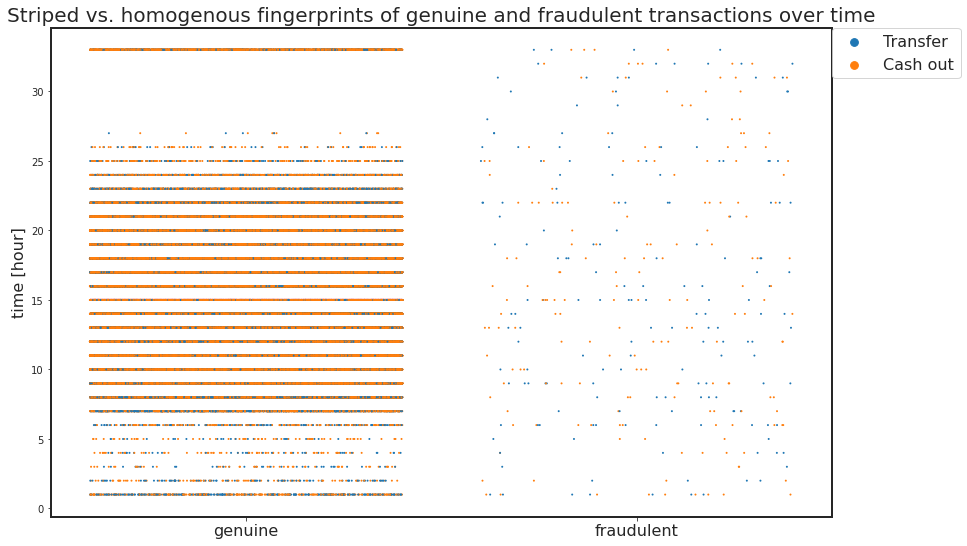

In [37]:
ax = plotStrip(Y[:limit], X.step[:limit], X.type[:limit])
ax.set_ylabel('time [hour]', size = 16)
ax.set_title('Striped vs. homogenous fingerprints of genuine and fraudulent \
transactions over time', size = 20);

The two plots below shows that although the presence of fraud in a transaction can be discerned by the original amount feature, the new errorBalanceDest feature is more effective at making a distinction.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


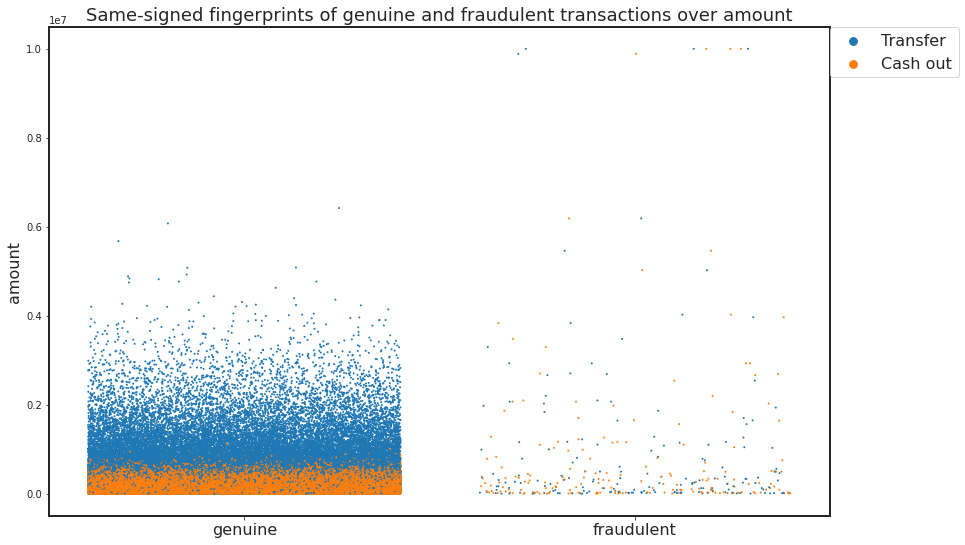

In [39]:
limit = len(X)
ax = plotStrip(Y[:limit], X.amount[:limit], X.type[:limit], figsize = (14, 9))
ax.set_ylabel('amount', size = 16)
ax.set_title('Same-signed fingerprints of genuine \
and fraudulent transactions over amount', size = 18);

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


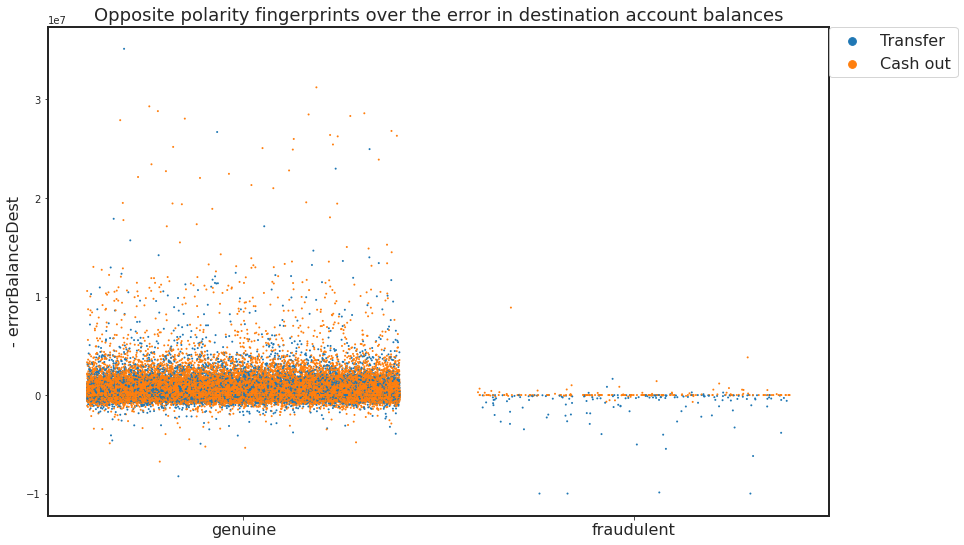

In [40]:
limit = len(X)
ax = plotStrip(Y[:limit], - X.errorBalanceDest[:limit], X.type[:limit], \
              figsize = (14, 9))
ax.set_ylabel('- errorBalanceDest', size = 16)
ax.set_title('Opposite polarity fingerprints over the error in \
destination account balances', size = 18);

 Separating out genuine from fraudulent transactions

The 3D plot below distinguishes best between fraud and non-fraud data by using both of the engineered error-based features. Clearly, the original step feature is ineffective in seperating out fraud. Note the striped nature of the genuine data vs time which was aniticipated from the figure 

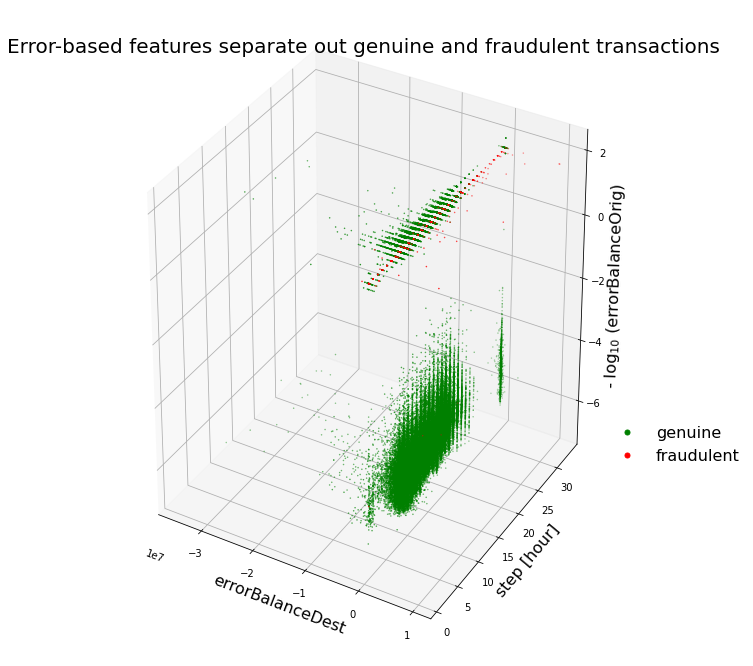

In [41]:
# Long computation in this cell (~2.5 minutes)
x = 'errorBalanceDest'
y = 'step'
z = 'errorBalanceOrig'
zOffset = 0.02
limit = len(X)

sns.reset_orig() # prevent seaborn from over-riding mplot3d defaults

fig = plt.figure(figsize = (10, 12))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X.loc[Y == 0, x][:limit], X.loc[Y == 0, y][:limit], \
  -np.log10(X.loc[Y == 0, z][:limit] + zOffset), c = 'g', marker = '.', \
  s = 1, label = 'genuine')
    
ax.scatter(X.loc[Y == 1, x][:limit], X.loc[Y == 1, y][:limit], \
  -np.log10(X.loc[Y == 1, z][:limit] + zOffset), c = 'r', marker = '.', \
  s = 1, label = 'fraudulent')

ax.set_xlabel(x, size = 16); 
ax.set_ylabel(y + ' [hour]', size = 16); 
ax.set_zlabel('- log$_{10}$ (' + z + ')', size = 16)
ax.set_title('Error-based features separate out genuine and fraudulent \
transactions', size = 20)

plt.axis('tight')
ax.grid(1)

noFraudMarker = mlines.Line2D([], [], linewidth = 0, color='g', marker='.',
                          markersize = 10, label='genuine')
fraudMarker = mlines.Line2D([], [], linewidth = 0, color='r', marker='.',
                          markersize = 10, label='fraudulent')

plt.legend(handles = [noFraudMarker, fraudMarker], \
           bbox_to_anchor = (1.20, 0.38 ), frameon = False, prop={'size': 16});

Smoking gun and comprehensive evidence embedded in the dataset of the difference between fraudulent and genuine transactions is obtained by examining their respective correlations in the heatmaps below.

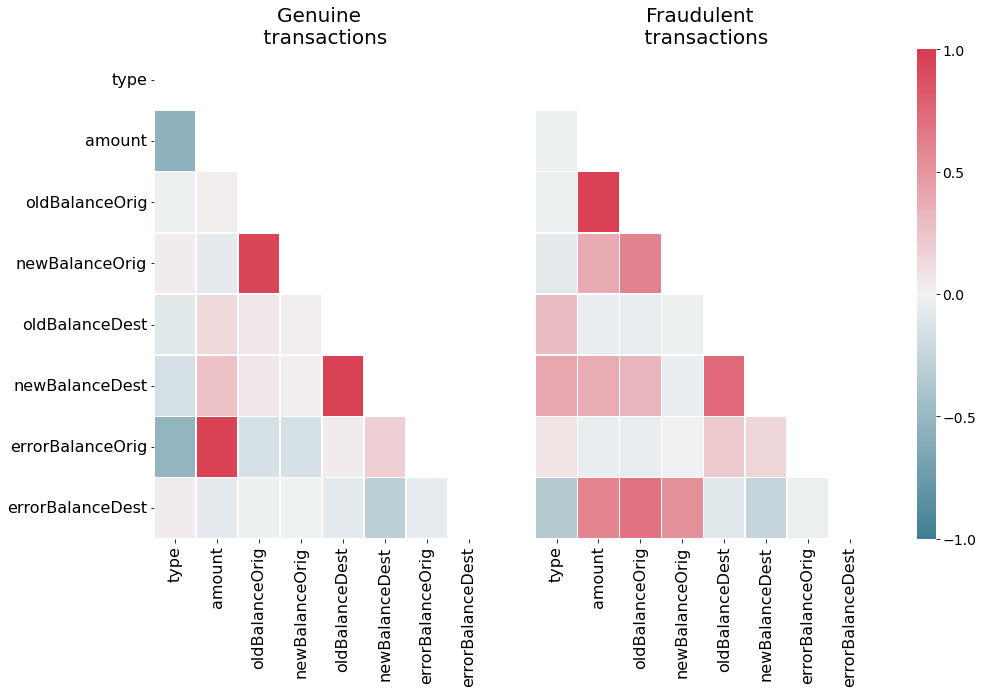

In [42]:
Xfraud = X.loc[Y == 1] # update Xfraud & XnonFraud with cleaned data
XnonFraud = X.loc[Y == 0]
                  
correlationNonFraud = XnonFraud.loc[:, X.columns != 'step'].corr()
mask = np.zeros_like(correlationNonFraud)
indices = np.triu_indices_from(correlationNonFraud)
mask[indices] = True

grid_kws = {"width_ratios": (.9, .9, .05), "wspace": 0.2}
f, (ax1, ax2, cbar_ax) = plt.subplots(1, 3, gridspec_kw=grid_kws, \
                                     figsize = (14, 9))

cmap = sns.diverging_palette(220, 8, as_cmap=True)
ax1 =sns.heatmap(correlationNonFraud, ax = ax1, vmin = -1, vmax = 1, \
    cmap = cmap, square = False, linewidths = 0.5, mask = mask, cbar = False)
ax1.set_xticklabels(ax1.get_xticklabels(), size = 16); 
ax1.set_yticklabels(ax1.get_yticklabels(), size = 16); 
ax1.set_title('Genuine \n transactions', size = 20)

correlationFraud = Xfraud.loc[:, X.columns != 'step'].corr()
ax2 = sns.heatmap(correlationFraud, vmin = -1, vmax = 1, cmap = cmap, \
 ax = ax2, square = False, linewidths = 0.5, mask = mask, yticklabels = False, \
    cbar_ax = cbar_ax, cbar_kws={'orientation': 'vertical', \
                                 'ticks': [-1, -0.5, 0, 0.5, 1]})
ax2.set_xticklabels(ax2.get_xticklabels(), size = 16); 
ax2.set_title('Fraudulent \n transactions', size = 20);

cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(), size = 14);

**6. Machine Learning to Detect Fraud in Skewed Datat**

Having obtained evidence from the plots above that the data now contains features that make fraudulent transactions clearly detectable, the remaining obstacle for training a robust ML model is the highly imbalanced nature of the data.

In [43]:
print('skew = {}'.format( len(Xfraud) / float(len(X)) ))

skew = 0.0013924914675767918


**Selection of metric:**
 Since the data is highly skewed, I use the area under the precision-recall curve (AUPRC) rather than the conventional area under the receiver operating characteristic (AUROC). This is because the AUPRC is more sensitive to differences between algorithms and their parameter settings rather than the AUROC 


Selection of ML algorithm: A first approach to deal with imbalanced data is to balance it by discarding the majority class before applying an ML algorithm. The disadvantage of undersampling is that a model trained in this way will not perform well on real-world skewed test data since almost all the information was discarded. A better approach might be to oversample the minority class, say by the synthetic minority oversampling technique (SMOTE) contained in the 'imblearn' library. Motivated by this, I tried a variety of anomaly-detection and supervised learning approaches. I find, however, that the best result is obtained on the original dataset by using a ML algorithm based on ensembles of decision trees that intrinsically performs well on imbalanced data. Such algorithms not only allow for constructing a model that can cope with the missing values in our data, but they naturally allow for speedup via parallel-processing. Among these algorithms, the extreme gradient-boosted (XGBoost) algorithm used below slightly outperforms random-forest. Finally, XGBoost, like several other ML algorithms, allows for weighting the positive class more compared to the negative class --- a setting that also allows to account for the skew in the data.

Split the data into training and test sets in a 80:20 ratio

In [47]:
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.2, \
                                                random_state = randomState)

In [48]:
# Long computation in this cell 
weights = (Y == 0).sum() / (1.0 * (Y == 1).sum())
clf = XGBClassifier(max_depth = 3, scale_pos_weight = weights, \
                n_jobs = 4)
probabilities = clf.fit(trainX, trainY).predict_proba(testX)
print('AUPRC = {}'.format(average_precision_score(testY, \
                                              probabilities[:, 1])))

AUPRC = 0.9416307342005902


**What are the important features for the ML model?**
The figure below shows that the new feature errorBalanceOrig that we created is the most relevant feature for the model. The features are ordered based on the number of samples affected by splits on those features.

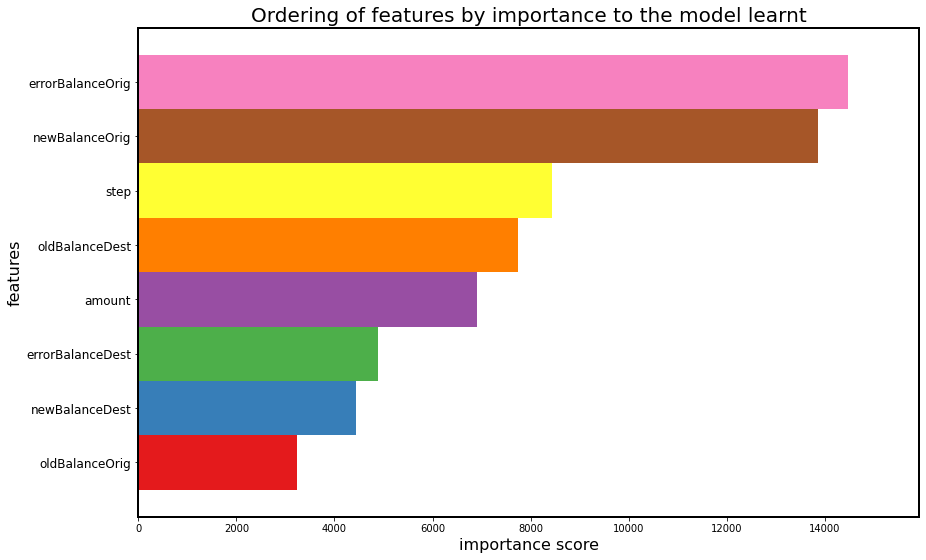

In [49]:
fig = plt.figure(figsize = (14, 9))
ax = fig.add_subplot(111)

colours = plt.cm.Set1(np.linspace(0, 1, 9))

ax = plot_importance(clf, height = 1, color = colours, grid = False, \
                     show_values = False, importance_type = 'cover', ax = ax);
for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)
        
ax.set_xlabel('importance score', size = 16);
ax.set_ylabel('features', size = 16);
ax.set_yticklabels(ax.get_yticklabels(), size = 12);
ax.set_title('Ordering of features by importance to the model learnt', size = 20);

**Visualization of ML model**

The root node in the decision tree visualized below is indeed the feature errorBalanceOrig, as would be expected from its high significance to the model.

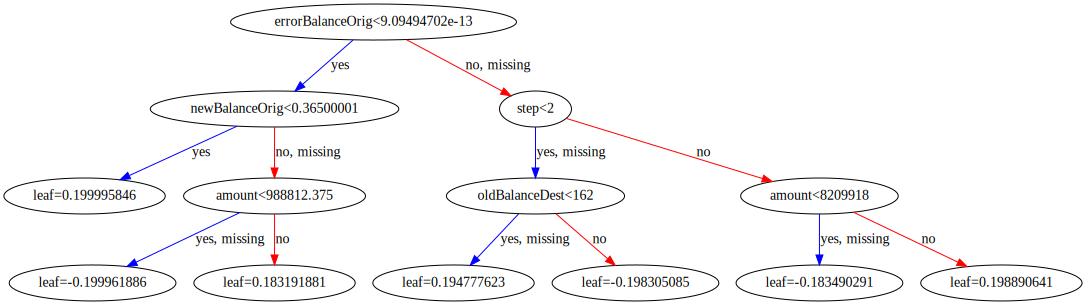

In [50]:
to_graphviz(clf)

**Bias-variance tradeoff**

The model we have learnt has a degree of bias and is slighly underfit. This is indicated by the levelling in AUPRC as the size of the training set is increased in the cross-validation curve below. The easiest way to improve the performance of the model still further is to increase the max_depth parameter of the XGBClassifier at the expense of the longer time spent learning the model. Other parameters of the classifier that can be adjusted to correct for the effect of the modest underfitting include decreasing min_child_weight and decreasing reg_lambda.

In [51]:
# Long computation in this cell 

trainSizes, trainScores, crossValScores = learning_curve(\
XGBClassifier(max_depth = 3, scale_pos_weight = weights, n_jobs = 4), trainX,\
                                         trainY, scoring = 'average_precision')

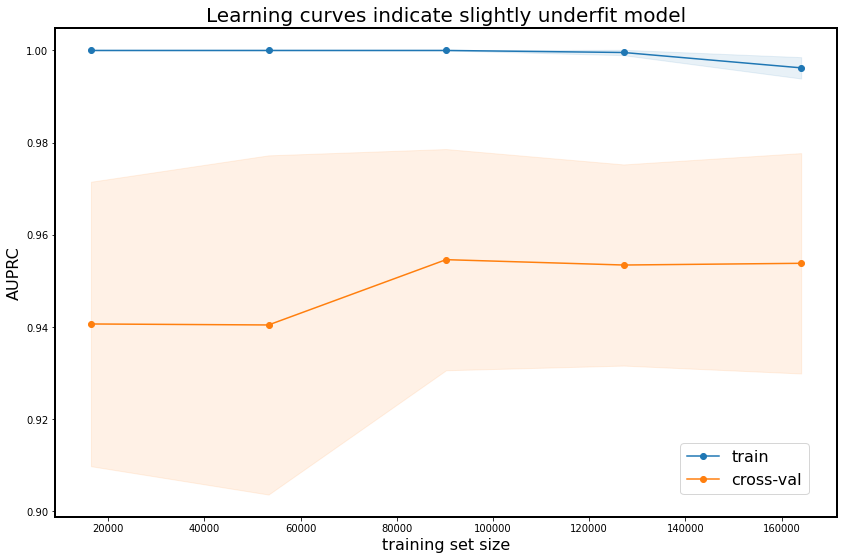

In [52]:
trainScoresMean = np.mean(trainScores, axis=1)
trainScoresStd = np.std(trainScores, axis=1)
crossValScoresMean = np.mean(crossValScores, axis=1)
crossValScoresStd = np.std(crossValScores, axis=1)

colours = plt.cm.tab10(np.linspace(0, 1, 9))

fig = plt.figure(figsize = (14, 9))
plt.fill_between(trainSizes, trainScoresMean - trainScoresStd,
    trainScoresMean + trainScoresStd, alpha=0.1, color=colours[0])
plt.fill_between(trainSizes, crossValScoresMean - crossValScoresStd,
    crossValScoresMean + crossValScoresStd, alpha=0.1, color=colours[1])
plt.plot(trainSizes, trainScores.mean(axis = 1), 'o-', label = 'train', \
         color = colours[0])
plt.plot(trainSizes, crossValScores.mean(axis = 1), 'o-', label = 'cross-val', \
         color = colours[1])

ax = plt.gca()
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, ['train', 'cross-val'], bbox_to_anchor=(0.8, 0.15), \
               loc=2, borderaxespad=0, fontsize = 16);
plt.xlabel('training set size', size = 16); 
plt.ylabel('AUPRC', size = 16)
plt.title('Learning curves indicate slightly underfit model', size = 20);